In [34]:
import numpy as np
import configparser
import matplotlib.pyplot as plt



In [35]:





def generate_step_discharge_profile(config_path, discharge_current=None, soc_start=0.9, soc_end=0.1, soc_step=0.1):
    """
    Generate a sparse current profile to discharge a battery in steps of 10% SOC,
    with 20 min rest after each step and 1 hour final relaxation.
    Also prints total discharged capacity in Ah.
    """
    # === Load battery capacity from config ===
    config = configparser.ConfigParser()
    config.read(config_path)

    capacity_Ah = float(config["battery"]["capacity_Ah"])
    if discharge_current is None:
        discharge_current = capacity_Ah * float(config["battery"]["c_rate"])

    Q_As = capacity_Ah * 3600  # Total capacity in As
    step_charge = soc_step * Q_As  # Charge removed per step in As
    t_discharge = step_charge / discharge_current  # Time to discharge 10% SOC

    rest_time = 20 * 60     # 20 minutes rest
    relax_time = 60 * 60    # 1 hour final relaxation

    profile = []
    t = 0
    soc = soc_start

    discharged_As = 0  # accumulator

    while soc - soc_step >= soc_end - 1e-4:
        # Step discharge
        profile.append([t, discharge_current])
        t_end = t + t_discharge
        profile.append([t_end, 0.0])
        
        discharged_As += discharge_current * t_discharge
        t = t_end + rest_time
        soc -= soc_step

    # Final 1-hour relaxation
    profile.append([t + relax_time, 0.0])

    discharged_Ah = discharged_As / 3600
    print(f"Total discharged capacity: {discharged_Ah:.3f} Ah")

    return np.array(profile)






def generate_step_discharge_profile_pwm(config_path, discharge_current=None, soc_start=0.9, soc_end=0.1, soc_step=0.1):
    """
    Generate a current profile to discharge a battery in steps of 10% SOC,
    where each step is done with a 20s ON / 10s OFF PWM pattern,
    followed by 20 min rest after each step and 1 hour final relaxation.
    Also prints total discharged capacity in Ah.
    """
    # === Load battery capacity from config ===
    config = configparser.ConfigParser()
    config.read(config_path)

    capacity_Ah = float(config["battery"]["capacity_Ah"])
    if discharge_current is None:
        discharge_current = capacity_Ah * float(config["battery"]["c_rate"])

    Q_As = capacity_Ah * 3600  # Total capacity in As
    step_charge = soc_step * Q_As  # Charge to remove per step in As

    rest_time = 20 * 60     # 20 minutes rest
    relax_time = 60 * 60    # 1 hour final relaxation

    pwm_on = 20    # 20 seconds ON
    pwm_off = 10   # 10 seconds OFF
    pwm_period = pwm_on + pwm_off

    profile = []
    t = 0
    soc = soc_start

    discharged_As = 0  # accumulator

    while soc - soc_step >= soc_end - 1e-4:
        # Discharge 10% SOC with PWM pulses
        charge_removed_this_step = 0

        while charge_removed_this_step < step_charge:
            # ON pulse
            profile.append([t, discharge_current])
            t_on_end = t + pwm_on
            charge_removed_this_step += discharge_current * pwm_on

            # OFF pulse
            profile.append([t_on_end, 0.0])
            t_off_end = t_on_end + pwm_off

            t = t_off_end

            if charge_removed_this_step >= step_charge:
                break

        # After discharging 10% SOC, rest for 20 minutes
        profile.append([t, 0.0])
        t += rest_time
        soc -= soc_step
        discharged_As += step_charge

    # Final 1-hour relaxation
    profile.append([t + relax_time, 0.0])

    discharged_Ah = discharged_As / 3600
    print(f"Total discharged capacity: {discharged_Ah:.3f} Ah")

    return np.array(profile)





Total discharged capacity: 141.600 Ah


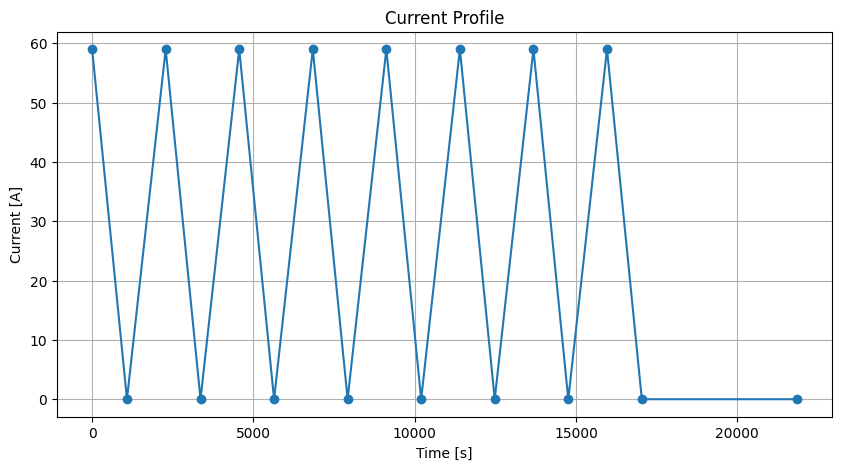

In [36]:

def create_simple_current_profile(duration=3600, step=600, current_values=[1, -1, 0]):
    """
    Create a simple current profile for testing.

    Parameters:
        duration: int
            Total duration of the profile in seconds.
        step: int
            Duration of each current step in seconds.
        current_values: list
            List of current values (A) for each step.

    Returns:
        np.ndarray: Array of (time [s], current [A]) pairs.
    """
    
    times = np.arange(0, duration + step, step)
    currents = np.resize(current_values, times.shape)
    profile = np.column_stack((times, currents))


    return profile

def plot_current_profile(current_profile):
    """
    Plot a current profile.

    Parameters:
        current_profile: np.ndarray or list of tuples
            Array or list of (time [s], current [A]) pairs.
    """

    # Ensure current_profile is a numpy array
    current_profile = np.array(current_profile)
    times = current_profile[:, 0]
    currents = current_profile[:, 1]

    plt.figure(figsize=(10, 5))
    plt.plot(times, currents, marker='o')
    plt.title("Current Profile")
    plt.xlabel("Time [s]")
    plt.ylabel("Current [A]")
    plt.grid()
    plt.show()


current_profile = generate_step_discharge_profile(config_path="battery_E60_module.config")
#current_profile = create_simple_current_profile(duration=3600, step=600, current_values=[1, -1, 0])

plot_current_profile(current_profile)




In [37]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d



def resample_current_profile(current_profile, sampling_rate=1):
    times = current_profile[:, 0]
    currents = current_profile[:, 1]
    
    t_min, t_max = times[0], times[-1]
    t_regular = np.arange(t_min, t_max + sampling_rate, sampling_rate)

    # Create step-wise interpolation (hold value until next change)
    step_interp = interp1d(times, currents, kind='previous', fill_value="extrapolate")

    c_regular = step_interp(t_regular)
    return np.column_stack((t_regular, c_regular))


def simulate_battery(current_profile, config_path, soc0=0.9, plot=True):
    import numpy as np
    from scipy.integrate import solve_ivp
    from scipy.interpolate import interp1d
    import configparser
    import matplotlib.pyplot as plt

    # === Load config ===
    config = configparser.ConfigParser()
    config.read(config_path)

    R0 = float(config["battery"]["R0"])
    R1 = float(config["battery"]["R1"])
    C1 = float(config["battery"]["C1"])

    # Load second RC parameters (add defaults if not present)
    R2 = float(config["battery"].get("R2", 0.0))
    C2 = float(config["battery"].get("C2", 1.0))  # Avoid division by zero if missing

    Q = float(config["battery"]["capacity_Ah"]) * 3600
    sampling_rate = float(config["battery"]["sampling_rate"])

    soc_vals_raw = [float(x) for x in config["soc_ocv"]["soc"].split(",")]
    ocv_vals_raw = [float(x) for x in config["soc_ocv"]["ocv"].split(",")]

    # Reverse arrays if SOC is in decreasing order (e.g., 100 → 0)
    if soc_vals_raw[0] > soc_vals_raw[-1]:
        soc_vals_raw.reverse()
        ocv_vals_raw.reverse()

    soc_vals = np.array(soc_vals_raw) / 100  # normalize to 0-1
    ocv_vals = np.array(ocv_vals_raw)

    OCV_fun = interp1d(soc_vals, ocv_vals, kind='cubic', fill_value="extrapolate")

    # Neue feinere SoC-Werte (e.g., 1000 points from 0 to 1)
    soc_vals_interp = np.linspace(0, 1, 1000)
    ocv_vals_interp = OCV_fun(soc_vals_interp)

    # === Ensure sampling rate ===
    times = current_profile[:, 0]
    currents = current_profile[:, 1]

    def I_func(t):
        return np.interp(t, times, currents)

    # === ODE system: [SOC, Vrc1, Vrc2] ===
    def battery_model(t, y):
        soc, vrc1, vrc2 = y
        I = I_func(t)
        dSOC_dt = -I / Q
        if R1 != 0:
            dVrc1_dt = (-vrc1 + I * R1) / (R1 * C1)
        else:
            dVrc1_dt = 0.0
        
        if R2 != 0:
            dVrc2_dt = (-vrc2 + I * R2) / (R2 * C2)
        else:
            dVrc2_dt = 0.0
            
        return [dSOC_dt, dVrc1_dt, dVrc2_dt]

    y0 = [soc0, 0.0, 0.0]
    t_span = (times[0], times[-1])
    t_eval = np.arange(times[0], times[-1] + sampling_rate, sampling_rate)

    sol = solve_ivp(battery_model, t_span, y0, t_eval=t_eval, method="RK45")
    soc = sol.y[0]
    v_rc1 = sol.y[1]
    v_rc2 = sol.y[2]
    I_out = np.array([I_func(ti) for ti in t_eval])
    OCV_out = OCV_fun(soc)
    voltage = OCV_out - R0 * I_out - v_rc1 - v_rc2
    v_r0 = R0 * I_out  # voltage drop on ohmic resistor

# === Optional Plot ===
    if plot:
        plt.figure(figsize=(10, 10))

        plt.subplot(6, 1, 1)
        plt.plot(t_eval, I_out, label="Current", color="tab:blue")
        plt.ylabel("Current [A]")
        plt.grid()

        plt.subplot(6, 1, 2)
        plt.plot(t_eval, OCV_out, label="OCV", color="tab:orange")
        plt.plot(t_eval, voltage, label="Terminal V", color="tab:red", linestyle="--")
        plt.ylabel("Voltage [V]")
        plt.legend()
        plt.grid()

        plt.subplot(6, 1, 3)
        plt.plot(t_eval, soc * 100, label="SOC", color="tab:green")
        plt.ylabel("SOC [%]")
        plt.grid()

        plt.subplot(6, 1, 4)
        plt.plot(t_eval, v_rc1, label="Vrc1", color="tab:purple")
        plt.ylabel("Vrc1 [V]")
        plt.legend()
        plt.grid()

        plt.subplot(6, 1, 5)
        plt.plot(t_eval, v_rc2, label="Vrc2", color="tab:brown")
        plt.ylabel("Vrc2 [V]")
        plt.legend()
        plt.grid()

        plt.subplot(6, 1, 6)
        plt.plot(t_eval, v_r0, label="VR0 (I * R0)", color="tab:cyan")
        plt.xlabel("Time [s]")
        plt.ylabel("VR0 [V]")
        plt.legend()
        plt.grid()


        plt.tight_layout()
        plt.show()

    return t_eval, I_out, voltage, soc, OCV_out


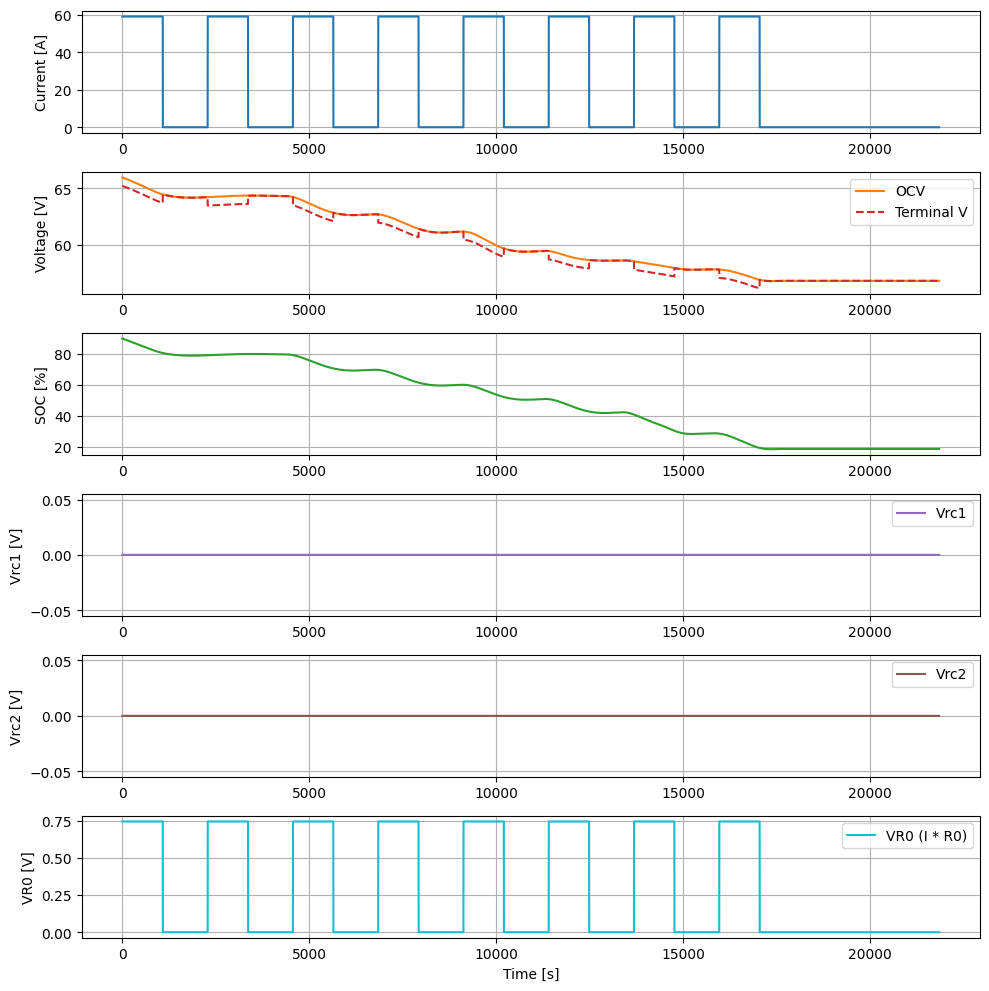

In [38]:

# Resample it to 1 Hz (1s intervals)
resampled_current = resample_current_profile(current_profile, sampling_rate=1)

# Simulate battery
t, I, V, SOC, OCV = simulate_battery(resampled_current, "battery_E60_module.config")



In [39]:
print("voltage:", V)
print("SOC:", SOC)

voltage: [65.22460743 65.22340952 65.22221074 ... 56.80555219 56.80555219
 56.80555219]
SOC: [0.9        0.89990741 0.89981482 ... 0.18425828 0.18425828 0.18425828]


In [40]:
from fmpy import *
from fmpy.util import plot_result
import os

# Pfad zur FMU
fmu_filename = 'StablModule_SOC_SOH_E60.fmu'




In [41]:
import numpy as np
# Create DataFrame first (for convenience)
input_df = pd.DataFrame({
    'time': t,
    'i_mod_avg': I,
    'i_mod_rms': I,
    'u_bat': V
})

inputv = np.array([
    ('i_mod_avg', I[0]),
    ('i_mod_rms', I[0]),
    ('u_bat', V[0])
])


# change the arrays that I have a time-varying input like this example: input={'input_var': [[0.0, 0.5], [5.0, 1.0]]},  # time-varying input
input = {
    'i_mod_avg': np.column_stack((t, I)),
    'i_mod_rms': np.column_stack((t, I)),
    'u_bat': np.column_stack((t, V))
}
print("input:", input)

# Save input data to CSV
input_csv_path = 'input_data.csv'
input_df.to_csv(input_csv_path, index=False)


#  create new csv with only the first value row
input_df_first_row = input_df.iloc[[0]]
# Save first row to CSV
input_csv_first_row_path = 'input_data_first_row.csv'
input_df_first_row.to_csv(input_csv_first_row_path, index=False)


NameError: name 'pd' is not defined

In [ ]:
from fmpy import *
fmu = 'StablModule_SOC_SOH_E60.fmu'
dump(fmu)


Model Info

  FMI Version        3.0
  FMI Type           Co-Simulation
  Model Name         StablModule_SOC_SOH
  Description        FMU for the estimation of SOC and SOH of a battery
  Platforms          win64
  Continuous States  0
  Event Indicators   0
  Variables          12
  Generation Tool    make
  Generation Date    2025-05-19T11:21:33+02:00

Default Experiment

  Stop Time          10.0
  Tolerance          0.0001
  Step Size          1.0

Variables (input, output)

  Name               Causality              Start Value  Unit     Description
  i_mod_rms          input                            0           
  i_mod_avg          input                            0           
  u_bat              input                            0           
  soc                output                                       
  soc_conf           output                                       
  soh                output                                       
  soh_conf           output         